# Scikit-Learn: Support Vector Machine (SVM) 

In this section we will use the `svm` module from the `sklearn` library to predict if the individual will earn over 50K or not. We will be implementing a `Support Vector Machine` model.

In [82]:
import numpy as np
import pandas as pd
import os, matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from itertools import combinations
from sklearn.preprocessing import LabelEncoder

---

## Load Processed Datasets

Read the preprocessed train/test feature matrices and labels, plus the validation features. These CSVs were produced earlier by the preprocessing pipeline (one-hot + numeric scaling), and will be the consistent input for all models.

In [83]:
# Reload features
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test  = pd.read_csv("../data/processed/X_test.csv")
X_val = pd.read_csv("../data/processed/X_val.csv")

# Reload targets (squeezed into Series)
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze("columns")
y_test  = pd.read_csv("../data/processed/y_test.csv").squeeze("columns")

# Align one-hot columns (safety)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
X_val  = X_val.reindex(columns=X_train.columns,  fill_value=0)

In [84]:
# To numpy
Xtr = X_train.to_numpy(dtype=np.float64, copy=False)
ytr_ppn = y_train.to_numpy(dtype=np.int64,  copy=False)   # Perceptron wants class labels
ytr_ada = y_train.to_numpy(dtype=np.float64, copy=False)  # Adaline learns on 0.0/1.0
Xte = X_test.to_numpy(dtype=np.float64,  copy=False)
yte = y_test.to_numpy(dtype=np.int64,    copy=False)
Xv  = X_val.to_numpy(dtype=np.float64,   copy=False)

---

## Plotting Functions

### Confusion Matrix

This function will help us plot our confusion matrix later on, so we can analyze our results. 

In [85]:
def plot_confusion_matrix(cm, y_true):
    """
    Plots the confusion matrix using a heatmap.

    Args:
        cm (np.ndarray): The confusion matrix.
        y_true (np.ndarray): The true labels for the test data.
    """
    # Create the plot using pure matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Use imshow to create the heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the unique class names
           xticklabels=np.unique(y_true), yticklabels=np.unique(y_true),
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

### SVM Decision Boundaries Plotting Function (Multi-Feature)

Plots the decision boundaries for multiple SVM models and multiple feature pairs, automatically handling non-numerical target labels and different data types for y.

In [86]:
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from matplotlib.lines import Line2D

def plot_svm_decision_boundaries_multi_feature(
    X, y, kernels, title_prefix="", C=1.0, gamma='scale',
    X_val=None, y_val=None, X_test=None, y_test=None,
    quantile_bounds=True, q_lo=0.1, q_hi=99.9, pad=0.12,
    figsize=(21, 5.5),
    train_alpha=0.35, test_alpha=0.55
):
    """Side-by-side SVM decision regions for one (or many) 2D feature pair(s).
       Overlays TEST points if provided. Uses alpha blending; no support-vector rings.
    """
    # ---- y -> 1D numpy (encode if needed) ----
    def _to_1d(y_like):
        if y_like is None: return None
        if isinstance(y_like, pd.DataFrame):
            if y_like.shape[1] != 1:
                raise ValueError("If 'y' is a DataFrame, it must have one column.")
            y_series = y_like.iloc[:, 0]
        elif isinstance(y_like, pd.Series):
            y_series = y_like
        elif isinstance(y_like, np.ndarray):
            y_series = pd.Series(y_like)
        else:
            raise TypeError("y must be a DataFrame, Series, or ndarray.")
        return y_series.to_numpy().reshape(-1)

    y_tr_arr  = _to_1d(y)
    y_val_arr = _to_1d(y_val) if y_val is not None else None
    y_te_arr  = _to_1d(y_test) if y_test is not None else None

    needs_encoding = any(arr is not None and arr.dtype.kind in ("O","U","S")
                         for arr in (y_tr_arr, y_val_arr, y_te_arr))
    if needs_encoding:
        le = LabelEncoder().fit(np.concatenate([a for a in (y_tr_arr, y_val_arr, y_te_arr) if a is not None]))
        y_tr = le.transform(y_tr_arr)
        y_v  = le.transform(y_val_arr) if y_val_arr is not None else None
        y_te = le.transform(y_te_arr)  if y_te_arr is not None else None
    else:
        y_tr, y_v, y_te = y_tr_arr, y_val_arr, y_te_arr
    # ------------------------------------------

    if X.shape[1] < 2:
        raise ValueError("Need at least 2 features.")
    feature_pairs = list(combinations(range(X.shape[1]), 2))
    n_pairs, n_kernels = len(feature_pairs), len(kernels)

    # Horizontal layout when single pair; no constrained_layout (we'll use tight_layout)
    if n_pairs == 1:
        fig, axes = plt.subplots(1, n_kernels, figsize=figsize, sharex=True, sharey=True)
        axes = np.array([axes]) if n_kernels > 1 else np.array([[axes]])
    else:
        fig, axes = plt.subplots(n_kernels, n_pairs, figsize=figsize, sharex='col', sharey='row')
        if n_kernels == 1 and n_pairs == 1: axes = np.array([[axes]])
        elif n_kernels == 1:               axes = np.array([axes])
        elif n_pairs == 1:                 axes = axes.reshape(-1, 1)

    # Legend proxies (no SV entry)
    dataset_legend = [
        Line2D([0],[0], marker='o', label='train', linestyle='', markerfacecolor='gray',
               markeredgecolor='none', markersize=7, alpha=train_alpha),
        Line2D([0],[0], marker='s', label='test',  linestyle='', markerfacecolor='gray',
               markeredgecolor='none', markersize=7, alpha=test_alpha),
    ]

    for i, kernel in enumerate(kernels):
        for j, (f1_idx, f2_idx) in enumerate(feature_pairs):
            ax = axes[0, i] if n_pairs == 1 else axes[i, j]

            # 2D slices
            X_pair = X.iloc[:, [f1_idx, f2_idx]]
            f1_name, f2_name = X.columns[f1_idx], X.columns[f2_idx]
            Xte_pair = X_test.iloc[:, [f1_idx, f2_idx]] if X_test is not None else None

            # finite rows only
            Xp = X_pair.to_numpy(dtype=np.float64, copy=False)
            yt = np.asarray(y_tr)
            msk = np.isfinite(Xp).all(axis=1) & np.isfinite(yt)
            X_fit, y_fit = Xp[msk], yt[msk]
            if np.unique(y_fit).size < 2 or X_fit.shape[0] < 2:
                ax.set_title(f"{kernel.capitalize()} ({f1_name} vs {f2_name}) — not enough class variety")
                ax.set_xlabel(f1_name); ax.set_ylabel(f2_name); continue

            # SVM
            if kernel == 'poly':
                model = SVC(kernel='poly', C=C, gamma=gamma, degree=3)
            else:
                model = SVC(kernel=kernel, C=C, gamma=gamma)
            model.fit(X_fit, y_fit)

            # bounds across train (+ test)
            xs = [X_pair.iloc[:,0]]; ys = [X_pair.iloc[:,1]]
            if Xte_pair is not None: xs.append(Xte_pair.iloc[:,0]); ys.append(Xte_pair.iloc[:,1])
            x_all = pd.concat(xs).to_numpy(); y_all = pd.concat(ys).to_numpy()
            if quantile_bounds:
                x_min, x_max = np.nanpercentile(x_all, [q_lo, q_hi])
                y_min, y_max = np.nanpercentile(y_all, [q_lo, q_hi])
            else:
                x_min, x_max = np.nanmin(x_all), np.nanmax(x_all)
                y_min, y_max = np.nanmin(y_all), np.nanmax(y_all)
            xr, yr = (x_max-x_min), (y_max-y_min)
            x_min -= pad*xr; x_max += pad*xr; y_min -= pad*yr; y_max += pad*yr

            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
            ax.contourf(xx, yy, Z, alpha=0.18, cmap=plt.cm.coolwarm)

            # Alpha-blended points (NO edgecolor → no black circles)
            ax.scatter(X_pair.iloc[:,0], X_pair.iloc[:,1], c=y_tr, cmap=plt.cm.coolwarm,
                       s=22, edgecolors='none', alpha=train_alpha, zorder=3)
            if Xte_pair is not None and y_test is not None:
                ax.scatter(Xte_pair.iloc[:,0], Xte_pair.iloc[:,1], c=y_test, cmap=plt.cm.coolwarm,
                           marker='s', s=24, edgecolors='none', alpha=test_alpha, zorder=4)

            ax.set_title(f"{kernel.capitalize()} ({f1_name} vs {f2_name})", pad=8)
            ax.set_xlabel(f1_name); ax.set_ylabel(f2_name)

    # Title & legend placement: no overlap
    if title_prefix:
        fig.suptitle(title_prefix, y=0.98, fontsize=13)
    # leave space top/bottom for suptitle & legend
    fig.tight_layout(rect=[0.02, 0.11, 1.00, 0.92])
    fig.legend(handles=dataset_legend, loc='lower center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 0.03))

    plt.show()


### SVM Decision Boundaries (Using GridSearchCV Parameters) Plotting Function (Multi-Feature)

Plots the decision boundaries for the best SVM model.

In [87]:
def plot_scatter_with_decision_regions(
    X_train2d, y_train,
    X_test2d=None, y_test=None,
    feature_names=("feature 1", "feature 2"),
    title="Train vs Test with Decision Regions",
    # classifier controls
    svc_params=None, classifier=None, fit_classifier=True,
    # look & feel
    train_alpha=0.25, test_alpha=0.45, region_alpha=0.18,
    quantile_bounds=True, q_lo=0.1, q_hi=99.9, pad=0.08,
    figsize=(8, 6),
    class_labels={0:"<=50K", 1:">50K"},   # <- color legend text
    savepath=None
):
    # --- accept DataFrame/Series or ndarray ---
    Xtr = X_train2d.to_numpy() if isinstance(X_train2d, pd.DataFrame) else np.asarray(X_train2d)
    ytr = np.asarray(y_train).reshape(-1)
    Xte = None; yte = None
    if X_test2d is not None: Xte = X_test2d.to_numpy() if isinstance(X_test2d, pd.DataFrame) else np.asarray(X_test2d)
    if y_test   is not None: yte = np.asarray(y_test).reshape(-1)

    # --- build/fit classifier (default: RBF SVC) ---
    if classifier is None:
        classifier = SVC(**(svc_params or dict(kernel='rbf', C=1.0, gamma='scale')))
    if fit_classifier:
        mask = np.isfinite(Xtr).all(axis=1) & np.isfinite(ytr)
        X_fit, y_fit = Xtr[mask], ytr[mask]
        if np.unique(y_fit).size < 2:
            raise ValueError("Need >=2 classes to draw decision regions.")
        classifier.fit(X_fit, y_fit)

    # --- grid bounds (robust) ---
    xs = [Xtr[:,0]]; ys = [Xtr[:,1]]
    if Xte is not None: xs.append(Xte[:,0]); ys.append(Xte[:,1])
    x_all, y_all = np.concatenate(xs), np.concatenate(ys)
    if quantile_bounds:
        x_min, x_max = np.nanpercentile(x_all, [q_lo, q_hi])
        y_min, y_max = np.nanpercentile(y_all, [q_lo, q_hi])
    else:
        x_min, x_max = np.nanmin(x_all), np.nanmax(x_all)
        y_min, y_max = np.nanmin(y_all), np.nanmax(y_all)
    xr, yr = (x_max-x_min), (y_max-y_min)
    x_min -= pad*xr; x_max += pad*xr; y_min -= pad*yr; y_max += pad*yr

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # --- plot ---
    fig, ax = plt.subplots(figsize=figsize)
    ax.contourf(xx, yy, Z, alpha=region_alpha, cmap=plt.cm.coolwarm)

    sc_train = ax.scatter(Xtr[:,0], Xtr[:,1], c=ytr, cmap="coolwarm",
                          edgecolor="none", alpha=train_alpha, label="train", s=30)
    if Xte is not None and yte is not None:
        sc_test  = ax.scatter(Xte[:,0], Xte[:,1], c=yte, cmap="coolwarm",
                              marker="s", edgecolor="none", alpha=test_alpha, label="test", s=35)

    ax.set_xlabel(feature_names[0]); ax.set_ylabel(feature_names[1])
    ax.set_title(title)

    # ---- legends ----
    # 1) Class color legend (inside axes, top-right)
    cmap = plt.cm.coolwarm
    uniq = np.unique(np.concatenate([ytr, yte]) if yte is not None else ytr)
    uniq = np.sort(uniq)
    # map first class to blue-ish, second to red-ish
    color_map = {uniq[0]: cmap(0.05), uniq[-1]: cmap(0.95)} if len(uniq) >= 2 else {uniq[0]: cmap(0.5)}
    class_handles = [Patch(facecolor=color_map[c], edgecolor='none',
                           label=class_labels.get(int(c), str(c))) for c in uniq]
    leg_classes = ax.legend(handles=class_handles, title="Class color", loc="upper right", frameon=True)
    ax.add_artist(leg_classes)

    # 2) Dataset legend (train/test) OUTSIDE, centered below
    dataset_handles = [
        Line2D([0],[0], marker='o', linestyle='', label='train',
               markerfacecolor='gray', markeredgecolor='none', markersize=7, alpha=train_alpha),
        Line2D([0],[0], marker='s', linestyle='', label='test',
               markerfacecolor='gray', markeredgecolor='none', markersize=7, alpha=test_alpha),
    ]
    fig.legend(handles=dataset_handles, loc='lower center', ncol=2, frameon=False, bbox_to_anchor=(0.5, 0.01))

    # layout + optional save
    fig.tight_layout(rect=[0.02, 0.06, 1.00, 0.95])  # bottom room for legend, top for title
    if savepath:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        fig.savefig(savepath, dpi=220, bbox_inches='tight', facecolor='white')
    plt.show()

---

## Initial Model (No Hyperparameter Tunning)

In [88]:
# Train with linear kernel
model_linear = SVC(kernel='linear', C=1)
model_linear.fit(X_train, y_train.values.ravel())

,C,1
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [89]:
# Make predictions on the scaled test set.
y_pred = model_linear.predict(X_test)

Now we will display the results of our initial model's prediction on the test dataset.


--- Confusion Matrix ---
[[5513  421]
 [ 778 1103]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      5934
           1       0.72      0.59      0.65      1881

    accuracy                           0.85      7815
   macro avg       0.80      0.76      0.77      7815
weighted avg       0.84      0.85      0.84      7815



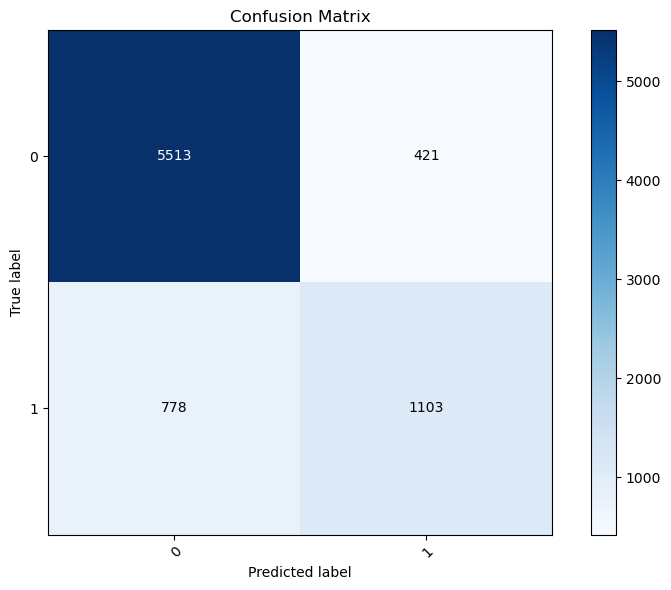

In [90]:
# Generate and display the confusion matrix and classification report
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

Accuracy is at 85%, leaning on the model’s strong recall for class `0` (93%), with 5,513 of 5,934 low earners correctly labeled. Class `1` remains tougher: recall nudges up to 59% (1,103 captured out of 1,881) while precision dips to 72%, so about one in four predicted high earners still earns less than $50 K. The confusion matrix shows 778 false negatives, meaning plenty of high earners slide through unnoticed—similar to the logistic baseline. Macro metrics lag the weighted ones, reinforcing that class imbalance and the harder positive class continue to limit gains even with the SVM.

Now we will select two features & visualize the decision boundaries with different kernels (`linear`, `rbf`, `poly`).

Top 2 numeric by MI: ['age', 'capital-gain']


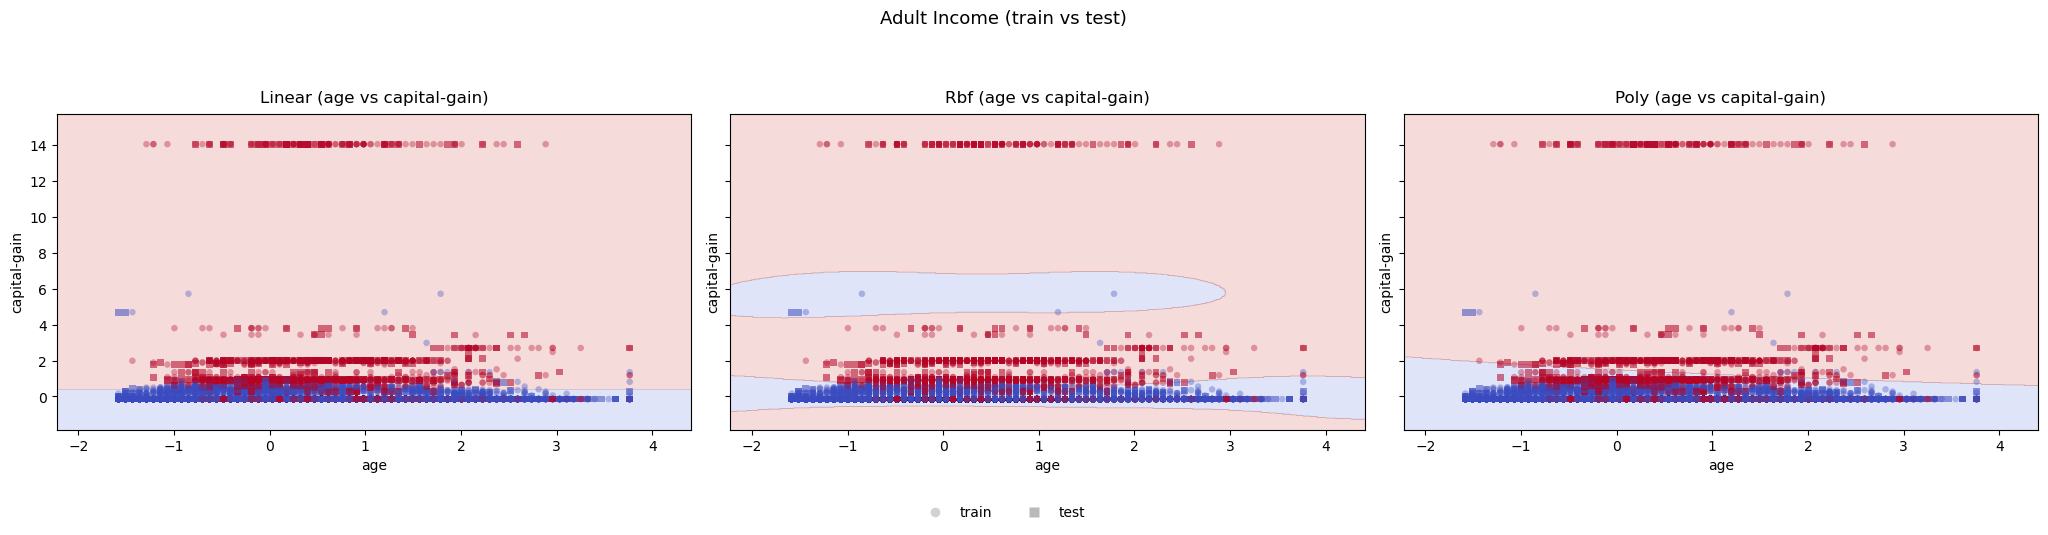

In [91]:
NUMERIC_CANDIDATES = [
    'age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week'
]
numeric_cols = [c for c in NUMERIC_CANDIDATES if c in X_train.columns]

# Pick top 2 numerics by MI (fit on TRAIN only)
k = min(2, len(numeric_cols))
selector = SelectKBest(mutual_info_classif, k=k).fit(X_train[numeric_cols], y_train)
top2_numeric = list(np.array(numeric_cols)[selector.get_support()])
print("Top 2 numeric by MI:", top2_numeric)

# Slice train/test with just those two columns
Xtr2 = X_train[top2_numeric]
Xte2 = X_test[top2_numeric]

# Plot: TRAIN as base, TEST overlaid 
plot_svm_decision_boundaries_multi_feature(
    Xtr2, y_train,
    kernels=['linear','rbf','poly'],
    X_test=Xte2, y_test=y_test,
    title_prefix="Adult Income (train vs test)",
    quantile_bounds=True, q_lo=0.1, q_hi=99.9, pad=0.12,
    figsize=(21, 5.5),
    train_alpha=0.35, test_alpha=0.55
)

- **Blue = Class 0 = `<=50k` income**
- **Red = Class 1 = `>50k` income**

- **Capital-gain is doing almost all the work**. The boundaries are mostly horizontal, so the prediction barely changes with age.
- **Higher capital-gain ⇒ more likely `>50K`**. As capital-gain increases, the background turns red across all ages.
- **Huge pile at capital-gain ≈ 0**. That dense band mixes blue and red points → this 2-feature view can’t separate many cases there.
- **Linear vs Poly look nearly the same**. Relationship in this plane is close to linear; polynomial doesn’t add much.
- **RBF finds one “bubble”** (a small blue island at moderate capital-gain). It captures a local pattern but doesn’t change the big picture.
- **Train vs Test look similar**. Circles (train) and squares (test) overlap in the same areas → no obvious train/test mismatch.

---

## GridSearchCV for Hyperparamter Tunning

Now we will use GridSearchCV to find the best hyperparameters for the model. Cross-validation (CV) helps to get a more robust estimate of model performance and prevents overfitting to a single train-test split.

In [92]:
# Define the parameter grid to search over.
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}


# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
grid_search.fit(X_train, y_train.values.ravel())

Starting hyperparameter search. This may take a moment...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


,estimator,SVC()
,param_grid,"{'C': [0.1, 1, ...], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf', ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1



--- Best Model Found by GridSearchCV ---
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8579

 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.8489

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      5934
           1       0.74      0.57      0.65      1881

    accuracy                           0.85      7815
   macro avg       0.81      0.75      0.77      7815
weighted avg       0.84      0.85      0.84      7815


Confusion Matrix:
[[5558  376]
 [ 805 1076]]


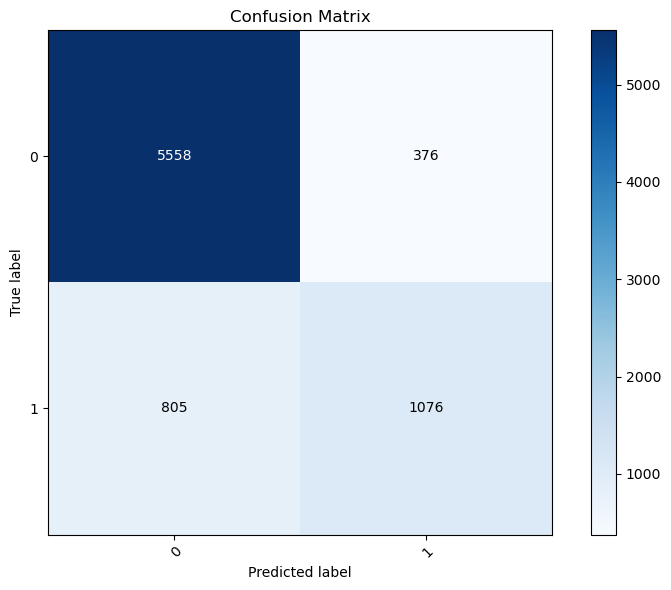

In [93]:
# Get the best estimator from the search.
best_model = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_y_pred)

print(f"Final accuracy on test set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, final_y_pred)
print(cm)

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

GridSearchCV chose an RBF SVC with `C=1` and `gamma='scale'`, delivering 85.8% cross-validation accuracy that closely matches the 84.9% test accuracy. On the test set it keeps class `0` recall high at 94% but still struggles with class `1`, reaching only 57% recall despite 74% precision. The confusion matrix shows 376 false alarms on low earners and 805 missed high earners, highlighting that most errors come from under-detecting the >$50 K group.

---

## Principla Component Analysis

We will now perform PCA without assumig a fixed number of components. Running PCA after GridSearchCV reduces the tuned SVM’s feature space to visualize and assess how separable the classes become once the best hyperparameters are locked in.


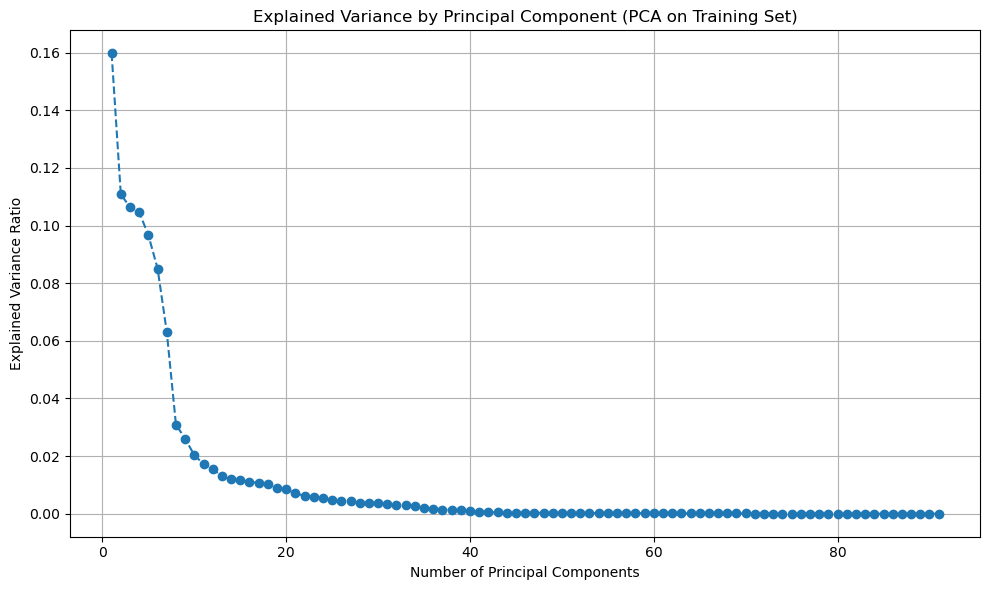

In [94]:
# By default, PCA will compute all n_features components.
pca = PCA()
pca.fit(X_train) # this is on x train to compare performance 

plt.figure(figsize=(10, 6))
explained_variance_ratio = pca.explained_variance_ratio_
components = range(1, len(explained_variance_ratio) + 1)
plt.plot(components, explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Component (PCA on Training Set)')
plt.grid(True)

# Save into outputs/graphs folder
plt.tight_layout()
plt.savefig("../outputs/graphs/svm_pca_scree_train.png")

plt.show()

- **PC1 ≈ 16%** of variance — by far the biggest single factor.
- **PC2–PC6** still matter (roughly **11% → 6%** each), then contributions drop fast.
- Clear **elbow around PC7–PC10** (≈3% and falling).
- After **~20 PCs**, each adds **<1%**; after **~40**, they’re near **0%** → long, flat tail.

**Implications**
- For compact models/plots, **~10–15 PCs** will capture most of the useful structure.
- Targeting **95% cumulative variance**, expect to need **~20–30 PCs**.

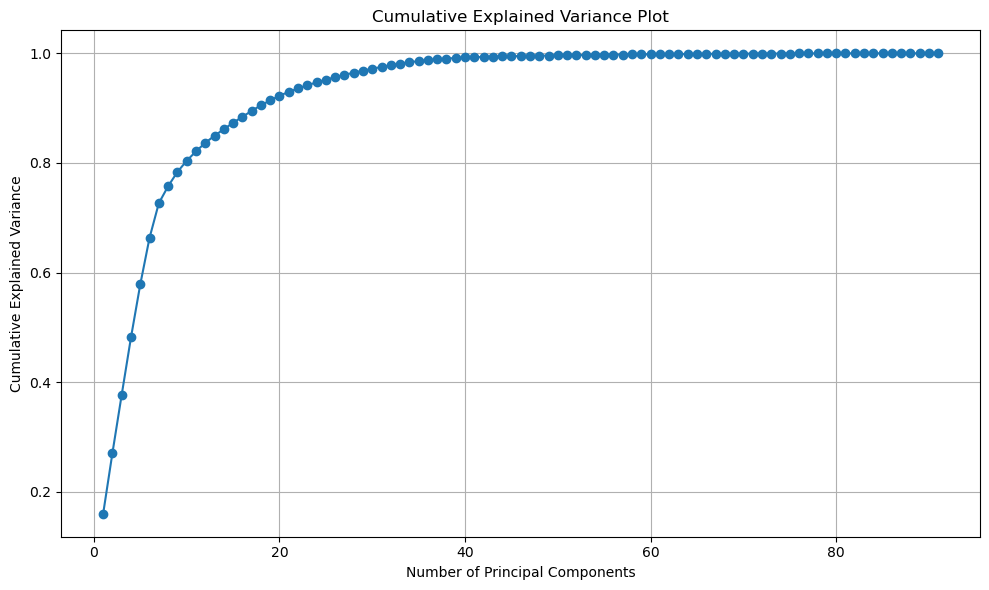

In [95]:
# Create the Cumulative Explained Variance Plot
plt.figure(figsize=(10, 6))
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(components, cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.grid(True)

# Save into outputs/graphs folder
plt.tight_layout()
plt.savefig("../outputs/graphs/svm-cumulative_explained_variance.png")

plt.show()

- Very steep start → the first **~6–7** PCs capture roughly **50–60%** of variance.
- About **~12 PCs ≈ 80%** cumulative variance (good compact baseline).
- Around **~18–22 PCs ≈ 90%**.
- Roughly **~28–32 PCs ≈ 95%**.
- By **~38–42 PCs ≈ 99%**; after that it’s a flat tail (tiny marginal gains).

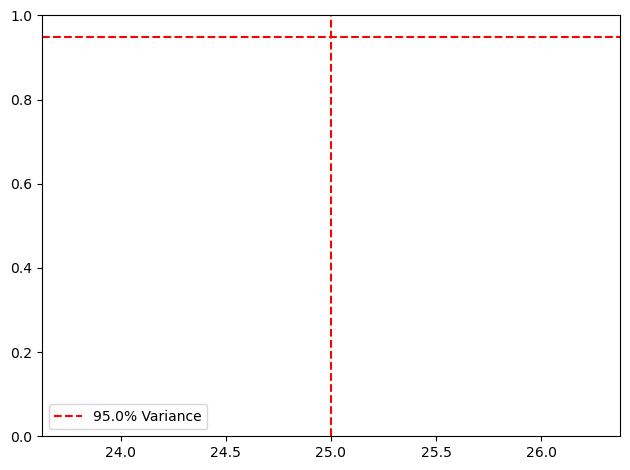

In [96]:
# Highlight a target variance, e.g., 95%
target_variance = 0.95
num_components_95 = np.argmax(cumulative_variance >= target_variance) + 1
plt.axvline(x=num_components_95, color='r', linestyle='--', label=f'{target_variance*100}% Variance')
plt.axhline(y=target_variance, color='r', linestyle='--')
plt.legend()

# Save into outputs/graphs folder
plt.tight_layout()
plt.savefig("../outputs/graphs/highlighting-target-variance.png")

plt.show()

- **95% variance is reached at ~25 principal components.**
- Past ~25, extra components add tiny marginal variance.
- Use **k = 25** as a solid default; still verify with CV because accuracy might plateau earlier/later than the variance threshold.

In [97]:
# Find the number of components for a target variance programmatically
num_components_for_95_percent = np.argmax(pca.explained_variance_ratio_.cumsum() >= 0.95) + 1
print(f"Number of components to explain 95% of variance: {num_components_for_95_percent}")

Number of components to explain 95% of variance: 25


### PCA (2D Projection) — Exploratory View of Class Separation

Here we are going to fit `PCA(n_components=2)` on the training set only (no leakage), then transforming train/test. Then we are plotting the train points in the PC1–PC2 plane, colored by class.

In [98]:
# use number of components created in PCA to plot
# Create a DataFrame for the principal components for easier plotting
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train) # Fit and transform training data
X_test_pca = pca.transform(X_test) # Transform the test data using the fitted PCA

pca_df = pd.DataFrame(data=X_train_pca, columns=['principal component 1', 'principal component 2'])
pca_df['target'] = y_train.values.ravel()

Explained variance ratio of the components:
[0.15977432 0.11083824]
Total variance explained: 0.27


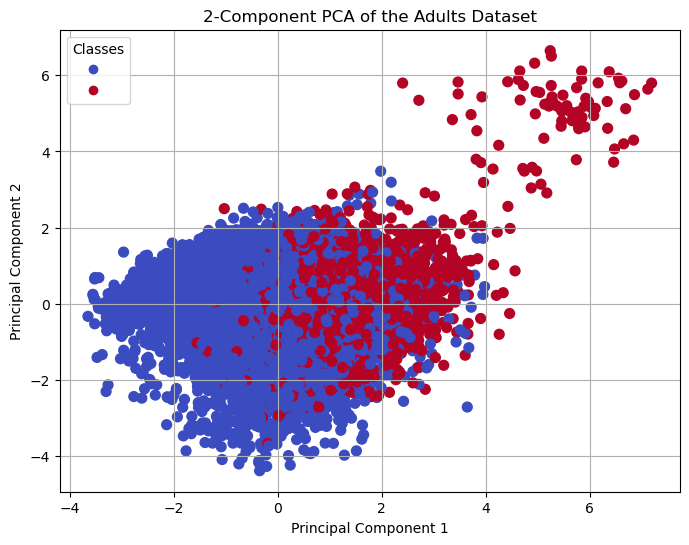

In [99]:
# Print the explained variance ratio
# This shows how much of the original data's variance is explained by each component.
print("Explained variance ratio of the components:")
print(pca.explained_variance_ratio_)
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2f}")

# Visualize the results
# Plot the first two principal components, colored by the target class.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_df['principal component 1'], pca_df['principal component 2'],
                      c=pca_df['target'], cmap=plt.cm.coolwarm, s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2-Component PCA of the Adults Dataset')
plt.legend(handles=scatter.legend_elements()[0], title="Classes")
plt.grid(True)
plt.show()

- **Partial separation**: There’s a red-heavy cluster toward the upper-right; those projected traits are associated with `>50K`.
- **Large overlap**: Blue and red mix heavily in the center → with only 2 PCs the classes are **not linearly separable**.
- **PC1 is most informative of the two** (bigger horizontal spread by class), PC2 adds some spread but less discrimination.
- **Takeaway**: Use more features/PCs for modeling; this 2-D view is mainly **exploratory**.

---

## Hyperparameter Search & Evaluation — PCA→SVC

We built a leakage-safe Pipeline that optionally applies PCA and then trains an SVM, and used GridSearchCV to tune both the number of components and the SVM hyperparameters via cross-validation. After selecting the best configuration, we evaluated it on the test set and reported performance (accuracy, classification report, confusion matrix), with earlier plots helping interpret feature structure and separability.

In [100]:
#pipe = Pipeline([
#    ('pca', PCA(random_state=0)),
#    ('svc', SVC())
#])

#param_grid = [
    # RBF
#    {'pca__n_components': [15, 20, 25, 30, 35],
#     'svc__kernel': ['rbf'],
#     'svc__C': [0.1, 1, 10],
#     'svc__gamma': ['scale', 'auto']},

    # Linear
#    {'pca__n_components': [15, 20, 25, 30, 35],
#     'svc__kernel': ['linear'],
#     'svc__C': [0.1, 1, 10]},

    # Poly
#    {'pca__n_components': [15, 20, 25, 30],
#     'svc__kernel': ['poly'],
#     'svc__degree': [2, 3],
#     'svc__C': [0.1, 1, 10],
#     'svc__gamma': ['scale', 'auto']},

    # Baseline: no PCA (compare)
#    {'pca': ['passthrough'],
#     'svc__kernel': ['rbf', 'linear'],
#     'svc__C': [0.1, 1, 10],
#     'svc__gamma': ['scale', 'auto']}  # gamma ignored for linear
#]

#cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#grid_search = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1, verbose=2, scoring='accuracy')
#grid_search.fit(X_train, y_train.values.ravel())

#print("Best params:", grid_search.best_params_)
#print("Best CV score: {:.3f}".format(grid_search.best_score_))

We hardcode the best GridSearchCV settings and comment out the previous GridSearchCV so later runs of this notebook can rebuild the tuned pipeline instantly; after the exhaustive search has already found the optimal hyperparameters, caching those values lets us skip the costly refit while keeping the model configuration exactly the same.


--- Best Model (cached) ---
Best parameters: {'pca': 'passthrough', 'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best cross-validation accuracy: 0.8570

Final accuracy on test set: 0.8489

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      5934
           1       0.74      0.57      0.65      1881

    accuracy                           0.85      7815
   macro avg       0.81      0.75      0.77      7815
weighted avg       0.84      0.85      0.84      7815


Confusion Matrix:
[[5558  376]
 [ 805 1076]]


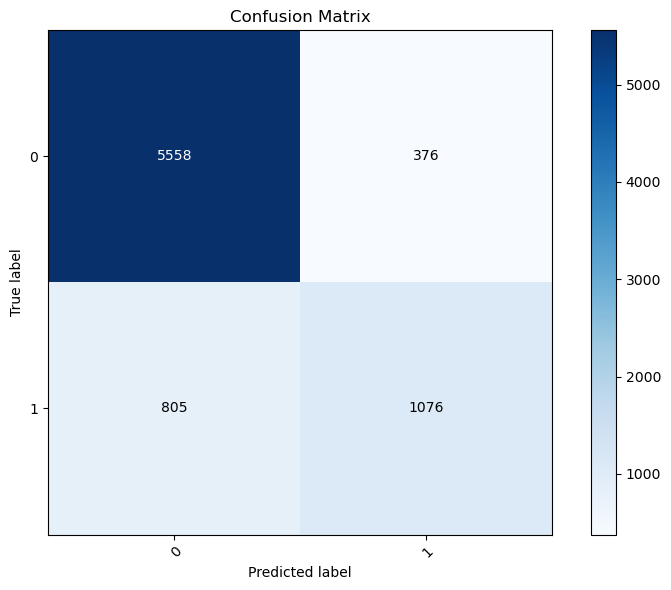

In [101]:
# Hard-code the best configuration discovered earlier
best_params = {
    "pca": "passthrough",
    "svc__C": 1,
    "svc__gamma": "scale",
    "svc__kernel": "rbf",
}
best_score = 0.8570  # cross-val score
test_accuracy = 0.8489

print("\n--- Best Model (cached) ---")
print("Best parameters:", best_params)
print(f"Best cross-validation accuracy: {best_score:.4f}")

# Recreate the final model using the cached params
best_model = Pipeline(
    steps=[
        ("pca", "passthrough"),
        ("svc", SVC(C=1, gamma="scale", kernel="rbf")),
    ]
)
best_model.fit(X_train, y_train)

final_y_pred = best_model.predict(X_test)

print(f"\nFinal accuracy on test set: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, final_y_pred)
print(cm)

plot_confusion_matrix(cm, y_test)


GridSearchCV preferred to skip PCA and keep an RBF SVC with `C=1`, `gamma='scale'`, reaching 85.7% cross-validation accuracy and 84.9% on the test set, so the model generalizes much like it did during tuning. Test performance mirrors the earlier SVC: class `0` maintains 94% recall and 87% precision, while class `1` stays limited to 57% recall despite 74% precision. The confusion matrix confirms that 376 low earners are falsely flagged and 805 high earners are missed, so most errors still come from under-detecting the >$50 K group.

---

## Predicting Outputs for `project_validation_inputs` & Visualizing Decision Boundaries on Final Model

Generating the required prediction files (0/1, one per line, no header) for `project_validation_inputs.csv`.

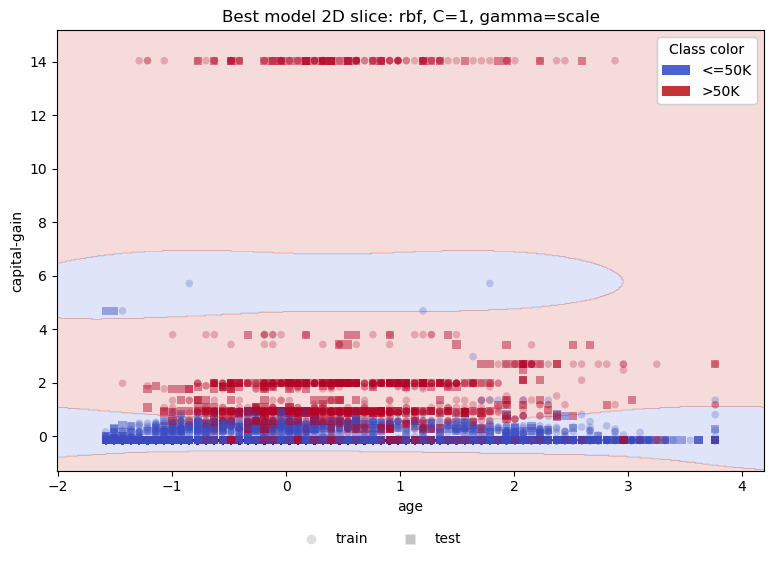

In [102]:
svc_best = best_model.named_steps['svc']
valid = SVC().get_params().keys()
svc_params = {k: v for k, v in svc_best.get_params().items() if k in valid}

# set output file name
out = f"../outputs/graphs/best_model_regions_{top2_numeric[0]}_vs_{top2_numeric[1]}_" \
      f"{svc_params['kernel']}_C{svc_params['C']}_gamma{svc_params.get('gamma','scale')}.png"

plot_scatter_with_decision_regions(
    Xtr2, y_train,
    Xte2, y_test,
    feature_names=tuple(top2_numeric),
    title=(f"Best model 2D slice: {svc_params['kernel']}, "
           f"C={svc_params['C']}, gamma={svc_params.get('gamma','scale')}"),
    svc_params=svc_params,
    class_labels={0:"<=50K", 1:">50K"},
    savepath=out
)


In [103]:
# Save SVC predictions (0/1)
pd.Series(best_model.predict(Xv)).to_csv(
    "../outputs/Group_18_SVM_PredictedOutputs.csv", 
    index=False, header=False
)

c:\Users\jonat\.conda\envs\DASC41103\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
